# Chapter 12 - Implementing a Multi-layer Artificial Neural Network from Scratch


<br>
<br>

# Classifying handwritten digits

## Obtaining the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 samples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 samples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

In this section, we will only be working with a subset of MNIST, thus, we only need to download the training set images and training set labels. After downloading the files, I recommend unzipping the files using the Unix/Linux gzip tool from the terminal for efficiency, e.g., using the command 

    gzip *ubyte.gz -d
 
in your local MNIST download directory, or, using your favorite unzipping tool if you are working with a machine running on Microsoft Windows. The images are stored in byte form, and using the following function, we will read them into NumPy arrays that we will use to train our MLP.


In [106]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [107]:
# unzips mnist

import sys
import gzip
import shutil

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 

In [108]:
X_train, y_train = load_mnist('', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [109]:
X_test, y_test = load_mnist('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


Visualize the first digit of each class:

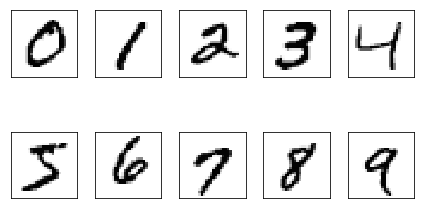

In [110]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_5.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

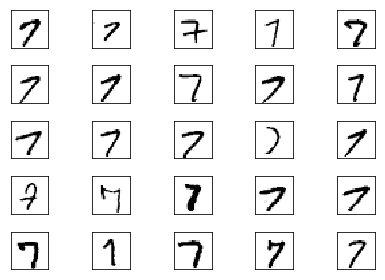

In [111]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

In [112]:
import numpy as np

np.savez_compressed('mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [113]:
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [114]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test']]

del mnist

X_train.shape

(60000, 784)

<br>
<br>

## Implementing a multi-layer perceptron

In [115]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [116]:
n_epochs = 100
accuracy = []


for i in range(1, 101):
    print(i)
    nn = NeuralNetMLP(n_hidden=i, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

    nn.fit(X_train=X_train[:55000], 
           y_train=y_train[:55000],
           X_valid=X_train[55000:],
           y_valid=y_train[55000:])

    accuracy.append(nn.eval_['valid_acc'][99])

1


100/100 | Cost: 149703.90 | Train/Valid Acc.: 23.28%/23.52% 

2


100/100 | Cost: 117783.67 | Train/Valid Acc.: 41.00%/41.22% 

3


100/100 | Cost: 85459.11 | Train/Valid Acc.: 65.02%/66.64%  

4


100/100 | Cost: 87191.86 | Train/Valid Acc.: 64.17%/65.58%  

5


100/100 | Cost: 58435.67 | Train/Valid Acc.: 83.35%/85.46%  

6


100/100 | Cost: 56095.31 | Train/Valid Acc.: 84.18%/85.48%  

7


100/100 | Cost: 35870.35 | Train/Valid Acc.: 90.15%/91.38%  

8


100/100 | Cost: 33955.43 | Train/Valid Acc.: 91.11%/92.18%  

9


100/100 | Cost: 31874.04 | Train/Valid Acc.: 91.61%/92.04%  

10


100/100 | Cost: 27739.60 | Train/Valid Acc.: 92.71%/93.46%  

11


100/100 | Cost: 28526.20 | Train/Valid Acc.: 92.37%/93.30%  

12


100/100 | Cost: 24951.98 | Train/Valid Acc.: 93.65%/94.42%  

13


100/100 | Cost: 26918.34 | Train/Valid Acc.: 92.86%/93.58%  

14


100/100 | Cost: 24203.30 | Train/Valid Acc.: 93.63%/93.92%  

15


100/100 | Cost: 21367.78 | Train/Valid Acc.: 94.25%/94.36%  

16


100/100 | Cost: 21306.70 | Train/Valid Acc.: 94.63%/95.02%  

17


100/100 | Cost: 21511.26 | Train/Valid Acc.: 94.42%/94.86%  

18


100/100 | Cost: 19152.22 | Train/Valid Acc.: 95.13%/95.42%  

19


100/100 | Cost: 20091.53 | Train/Valid Acc.: 94.85%/94.92%  

20


100/100 | Cost: 17500.75 | Train/Valid Acc.: 95.75%/95.92%  

21


100/100 | Cost: 18750.60 | Train/Valid Acc.: 95.34%/95.46%  

22


100/100 | Cost: 17813.02 | Train/Valid Acc.: 95.54%/95.44%  

23


100/100 | Cost: 17321.78 | Train/Valid Acc.: 95.62%/95.82%  

24


100/100 | Cost: 16731.43 | Train/Valid Acc.: 96.08%/95.92%  

25


100/100 | Cost: 16228.13 | Train/Valid Acc.: 96.13%/96.34%  

26


100/100 | Cost: 15944.66 | Train/Valid Acc.: 96.17%/96.28%  

27


100/100 | Cost: 15243.35 | Train/Valid Acc.: 96.31%/96.22%  

28


100/100 | Cost: 14835.20 | Train/Valid Acc.: 96.40%/96.14%  

29


100/100 | Cost: 14925.34 | Train/Valid Acc.: 96.43%/96.26% 

30


100/100 | Cost: 14360.84 | Train/Valid Acc.: 96.67%/96.74% 

31


100/100 | Cost: 13527.90 | Train/Valid Acc.: 96.91%/96.60% 

32


100/100 | Cost: 14094.83 | Train/Valid Acc.: 96.72%/96.42% 

33


100/100 | Cost: 13281.03 | Train/Valid Acc.: 96.93%/96.66% 

34


100/100 | Cost: 14084.28 | Train/Valid Acc.: 96.70%/96.48% 

35


100/100 | Cost: 13046.92 | Train/Valid Acc.: 96.98%/96.72% 

36


100/100 | Cost: 13395.78 | Train/Valid Acc.: 96.88%/96.38% 

37


100/100 | Cost: 12624.94 | Train/Valid Acc.: 97.11%/96.22% 

38


100/100 | Cost: 13298.42 | Train/Valid Acc.: 96.95%/96.54% 

39


100/100 | Cost: 12392.64 | Train/Valid Acc.: 97.11%/96.98% 

40


100/100 | Cost: 11927.12 | Train/Valid Acc.: 97.32%/96.98% 

41


100/100 | Cost: 12562.01 | Train/Valid Acc.: 97.15%/97.10% 

42


100/100 | Cost: 11635.14 | Train/Valid Acc.: 97.43%/97.10% 

43


100/100 | Cost: 11382.85 | Train/Valid Acc.: 97.50%/97.24% 

44


100/100 | Cost: 11197.19 | Train/Valid Acc.: 97.56%/96.90% 

45


100/100 | Cost: 11578.25 | Train/Valid Acc.: 97.45%/97.30% 

46


100/100 | Cost: 11160.86 | Train/Valid Acc.: 97.58%/97.16% 

47


100/100 | Cost: 11505.11 | Train/Valid Acc.: 97.47%/97.10% 

48


100/100 | Cost: 10920.85 | Train/Valid Acc.: 97.62%/97.12% 

49


100/100 | Cost: 10920.97 | Train/Valid Acc.: 97.63%/97.20% 

50


100/100 | Cost: 10939.43 | Train/Valid Acc.: 97.57%/97.12% 

51


100/100 | Cost: 10939.01 | Train/Valid Acc.: 97.57%/97.18% 

52


100/100 | Cost: 11093.49 | Train/Valid Acc.: 97.53%/97.12% 

53


100/100 | Cost: 10473.42 | Train/Valid Acc.: 97.69%/97.34% 

54


100/100 | Cost: 10418.44 | Train/Valid Acc.: 97.74%/97.18% 

55


100/100 | Cost: 9978.72 | Train/Valid Acc.: 97.86%/97.28%  

56


100/100 | Cost: 10684.80 | Train/Valid Acc.: 97.65%/97.20% 

57


100/100 | Cost: 10036.81 | Train/Valid Acc.: 97.91%/97.26% 

58


100/100 | Cost: 9936.48 | Train/Valid Acc.: 97.89%/97.42%  

59


100/100 | Cost: 9874.88 | Train/Valid Acc.: 97.94%/97.54%  

60


100/100 | Cost: 9805.76 | Train/Valid Acc.: 97.94%/97.56%  

61


100/100 | Cost: 9723.62 | Train/Valid Acc.: 97.93%/97.54%  

62


100/100 | Cost: 9571.90 | Train/Valid Acc.: 97.99%/97.36%  

63


100/100 | Cost: 9629.96 | Train/Valid Acc.: 97.99%/97.44%  

64


100/100 | Cost: 9301.53 | Train/Valid Acc.: 98.15%/97.50%  

65


100/100 | Cost: 9474.84 | Train/Valid Acc.: 98.00%/97.54%  

66


100/100 | Cost: 9216.78 | Train/Valid Acc.: 98.10%/97.32%  

67


100/100 | Cost: 9669.19 | Train/Valid Acc.: 97.97%/97.14%  

68


100/100 | Cost: 9218.74 | Train/Valid Acc.: 98.08%/97.42%  

69


100/100 | Cost: 9196.96 | Train/Valid Acc.: 98.13%/97.56%  

70


100/100 | Cost: 8941.85 | Train/Valid Acc.: 98.16%/97.50%  

71


100/100 | Cost: 8962.79 | Train/Valid Acc.: 98.14%/97.52%  

72


100/100 | Cost: 9328.76 | Train/Valid Acc.: 98.12%/97.48%  

73


100/100 | Cost: 8906.92 | Train/Valid Acc.: 98.19%/97.68%  

74


100/100 | Cost: 8686.64 | Train/Valid Acc.: 98.25%/97.74%  

75


100/100 | Cost: 8802.34 | Train/Valid Acc.: 98.24%/97.52%  

76


100/100 | Cost: 8821.63 | Train/Valid Acc.: 98.18%/97.56%  

77


100/100 | Cost: 8719.00 | Train/Valid Acc.: 98.31%/97.56%  

78


100/100 | Cost: 8923.61 | Train/Valid Acc.: 98.19%/97.60%  

79


100/100 | Cost: 8526.38 | Train/Valid Acc.: 98.29%/97.82%  

80


100/100 | Cost: 8963.38 | Train/Valid Acc.: 98.13%/97.52%  

81


100/100 | Cost: 8679.84 | Train/Valid Acc.: 98.23%/97.52%  

82


100/100 | Cost: 8516.80 | Train/Valid Acc.: 98.32%/97.72%  

83


100/100 | Cost: 8471.02 | Train/Valid Acc.: 98.32%/97.56%  

84


100/100 | Cost: 8539.72 | Train/Valid Acc.: 98.25%/97.62%  

85


100/100 | Cost: 8639.29 | Train/Valid Acc.: 98.28%/97.66%  

86


100/100 | Cost: 8344.42 | Train/Valid Acc.: 98.33%/97.76%  

87


100/100 | Cost: 8337.20 | Train/Valid Acc.: 98.35%/97.78%  

88


100/100 | Cost: 7875.37 | Train/Valid Acc.: 98.49%/97.78%  

89


100/100 | Cost: 8138.13 | Train/Valid Acc.: 98.34%/97.54%  

90


100/100 | Cost: 8303.68 | Train/Valid Acc.: 98.33%/97.76%  

91


100/100 | Cost: 8004.03 | Train/Valid Acc.: 98.46%/97.74%  

92


100/100 | Cost: 8280.60 | Train/Valid Acc.: 98.30%/97.82%  

93


100/100 | Cost: 7952.73 | Train/Valid Acc.: 98.47%/97.64%  

94


100/100 | Cost: 8153.78 | Train/Valid Acc.: 98.42%/97.60%  

95


100/100 | Cost: 7722.32 | Train/Valid Acc.: 98.50%/98.10%  

96


100/100 | Cost: 8055.42 | Train/Valid Acc.: 98.37%/97.80%  

97


100/100 | Cost: 7819.63 | Train/Valid Acc.: 98.46%/97.74%  

98


100/100 | Cost: 7832.45 | Train/Valid Acc.: 98.49%/97.96%  

99


100/100 | Cost: 7787.66 | Train/Valid Acc.: 98.52%/97.68%  

100


100/100 | Cost: 7909.96 | Train/Valid Acc.: 98.47%/97.78%  

In [119]:
plt.plot(range(i), nn.eval_['train_acc'], 
         label='training')
plt.plot(range(i), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('N of hidden units')
plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
plt.show()

<br>
<br>